In [ ]:
import os
import time
import random
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm # Use notebook tqdm for Kaggle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import argparse
import kagglehub # Assuming kagglehub is installed and configured

# --- Configuration ---
# Using argparse for better hyperparameter management
parser = argparse.ArgumentParser(description='ViT Training for LFW from Scratch')
parser.add_argument('--img_size', type=int, default=128, help='Image size')
parser.add_argument('--patch_size', type=int, default=16, help='Patch size')
parser.add_argument('--batch_size', type=int, default=64, help='Batch size')
parser.add_argument('--min_imgs', type=int, default=15, help='Minimum images per person to include') # Increased significantly
parser.add_argument('--embed_dim', type=int, default=512, help='Embedding dimension')
parser.add_argument('--depth', type=int, default=6, help='Number of transformer blocks') # Reduced depth slightly
parser.add_argument('--num_heads', type=int, default=8, help='Number of attention heads')
parser.add_argument('--mlp_ratio', type=float, default=4.0, help='MLP hidden dimension ratio')
parser.add_argument('--dropout', type=float, default=0.3, help='Dropout rate') # Increased
parser.add_argument('--attn_dropout', type=float, default=0.3, help='Attention dropout rate') # Increased
parser.add_argument('--lr', type=float, default=1e-4, help='Maximum learning rate for OneCycleLR') # Reduced LR
parser.add_argument('--weight_decay', type=float, default=0.05, help='Weight decay (AdamW)') # Slightly increased WD
parser.add_argument('--epochs', type=int, default=100, help='Maximum number of epochs')
parser.add_argument('--patience', type=int, default=15, help='Early stopping patience') # Added early stopping
parser.add_argument('--seed', type=int, default=42, help='Random seed for reproducibility')
parser.add_argument('--data_dir', type=str, default=None, help='Path to dataset directory (will be set by kagglehub)')

# Kaggle notebooks often need this for argparse
# Use default args if not running from command line with arguments
args = parser.parse_args(args=[])

# --- Seed for Reproducibility ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(args.seed)

# --- Download Dataset ---
print("Downloading LFW dataset...")
# Use a temporary variable to store the path returned by kagglehub
dataset_download_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
args.data_dir = os.path.join(dataset_download_path, "lfw-deepfunneled/lfw-deepfunneled")
print(f"Dataset downloaded to: {dataset_download_path}")
print(f"Using image directory: {args.data_dir}")

# --- Dataset + Augmentation ---
# Stronger Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15), # Slightly increased rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1), # Stronger color jitter
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0), # Added Random Erasing
])

# Simple Augmentation for Validation
val_transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

class LFWDataset(Dataset):
    # Corrected __init__ definition
    def __init__(self, root_dir, transform=None, min_imgs=2):
        self.images = []
        self.labels = []
        self.transform = transform
        self.label_map = {}
        self.class_to_idx = {} # Keep track for mapping back if needed
        lbl_id = 0

        print(f"Loading dataset from {root_dir} with min_imgs={min_imgs}")
        if not os.path.isdir(root_dir):
             raise FileNotFoundError(f"Dataset directory not found: {root_dir}")

        # Iterate through person folders
        for person in os.listdir(root_dir):
            folder = os.path.join(root_dir, person)
            # Ensure it's a directory
            if not os.path.isdir(folder): continue

            imgs_in_folder = [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() == '.jpg']
            # Filter based on minimum images
            if len(imgs_in_folder) < min_imgs: continue

            # Assign label ID if not already done
            if person not in self.label_map:
                self.label_map[person] = lbl_id
                self.class_to_idx[lbl_id] = person # Store reverse mapping
                lbl_id += 1

            # Add images and labels to lists
            person_label_id = self.label_map[person]
            for img_name in imgs_in_folder:
                self.images.append(os.path.join(folder, img_name))
                self.labels.append(person_label_id)

        self.num_classes = len(self.label_map)
        print(f"Found {len(self.images)} images belonging to {self.num_classes} individuals (with >= {min_imgs} images each).")
        if self.num_classes == 0:
            print(f"Warning: No classes found with min_imgs={min_imgs}. Check data_dir or lower min_imgs.")


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder or skip? For now, let's return None and handle in DataLoader
            # Or, better, raise an error or return a dummy tensor if your training loop can handle it.
            # Let's create a dummy tensor matching expected output shape
            return torch.zeros((3, args.img_size, args.img_size)), -1 # Return invalid label

        if self.transform:
            img = self.transform(img)

        return img, label

# --- Instantiate + Split Dataset ---
# Important: Create separate dataset instances for train and val transforms
full_train_dataset = LFWDataset(args.data_dir, transform=train_transform, min_imgs=args.min_imgs)
full_val_dataset   = LFWDataset(args.data_dir, transform=val_transform,   min_imgs=args.min_imgs)

# Ensure we have data before proceeding
if len(full_train_dataset) == 0:
    raise ValueError("Dataset is empty. Check `min_imgs` or `data_dir`.")

NUM_CLASSES = full_train_dataset.num_classes
print(f"Number of classes after filtering: {NUM_CLASSES}")

# Check if NUM_CLASSES > 0 before splitting
if NUM_CLASSES == 0:
     raise ValueError("No classes found to train on.")
elif NUM_CLASSES == 1:
    print("Warning: Only one class found after filtering. Classification training needs at least 2 classes.")
    # Handle this case if needed (e.g., exit or change task)
    # For now, we'll let it proceed, but train/val split might be trivial

# Generate indices once based on the labels from one of the datasets (they share the same structure)
indices = list(range(len(full_train_dataset)))
labels_for_split = full_train_dataset.labels

# Perform train/validation split
# Handle cases with very few samples where stratify might fail or be less meaningful
test_size = 0.2
if len(indices) < 5: # Need at least 1 sample per split per class for stratification with 2 classes
    print("Warning: Very few samples, using simple split.")
    train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=args.seed)
elif NUM_CLASSES > 1:
    try:
        train_idx, val_idx = train_test_split(indices,
                                            test_size=test_size,
                                            stratify=labels_for_split,
                                            random_state=args.seed)
    except ValueError as e:
         print(f"Stratified split failed ({e}), falling back to non-stratified split.")
         train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=args.seed)
else: # Only one class
    train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=args.seed)


# Create subset datasets using the generated indices
train_ds = torch.utils.data.Subset(full_train_dataset, train_idx)
val_ds   = torch.utils.data.Subset(full_val_dataset,   val_idx) # Use val_dataset for correct transforms

print(f"Train samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

# --- DataLoaders ---
# Handle potential errors in __getitem__ during loading
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None and x[1] != -1, batch)) # Filter out problematic samples
    if not batch:
        return torch.tensor([]), torch.tensor([]) # Return empty tensors if batch is empty
    return torch.utils.data.dataloader.default_collate(batch)


train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True,  num_workers=2, pin_memory=True, collate_fn=collate_fn) # Reduced num_workers for Kaggle
val_loader   = DataLoader(val_ds,   batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

# --- ViT Model Definition (Corrected __init__) ---
class PatchEmbedding(nn.Module):
    # Corrected __init__
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        # Projection layer
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Positional embedding (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.n_patches, embed_dim))
        # Initialize positional embedding
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)


    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}x{W}) doesn't match model ({self.img_size}x{self.img_size})."

        # Project patches: [B, C, H, W] -> [B, E, H/P, W/P]
        x = self.proj(x)
        # Flatten and transpose: [B, E, H/P, W/P] -> [B, E, N] -> [B, N, E]
        x = x.flatten(2).transpose(1, 2)
        # Prepend class token: [B, 1, E] + [B, N, E] -> [B, N+1, E]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # Add positional embedding
        x = x + self.pos_embed
        return x

class TransformerEncoder(nn.Module):
    # Corrected __init__
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, drop=0.1, attn_drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=attn_drop, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(drop),
        )
        # Note: Consider adding Stochastic Depth (DropPath) here for stronger regularization if needed

    def forward(self, x):
        # Self-Attention Block
        res = x
        x = self.norm1(x)
        attn_output, _ = self.attn(x, x, x)
        x = res + attn_output # Residual connection

        # MLP Block
        res = x
        x = self.norm2(x)
        x = res + self.mlp(x) # Residual connection
        return x

class ViT(nn.Module):
     # Corrected __init__
    def __init__(self,
                 img_size=128,
                 patch_size=16,
                 in_chans=3,
                 num_classes=1000,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 drop_rate=0.1,
                 attn_drop_rate=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        # Transformer Blocks
        self.blocks = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads, mlp_ratio, drop=drop_rate, attn_drop=attn_drop_rate)
            for _ in range(depth)])
        # Final normalization and classifier head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity() # Handle num_classes=0 case

        # Weight initialization (important for training from scratch)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x) # [B, N+1, E]
        # Pass through transformer blocks
        for blk in self.blocks:
            x = blk(x)
        # Final normalization (on CLS token)
        x = self.norm(x[:, 0]) # [B, E]
        # Classification head
        x = self.head(x) # [B, num_classes]
        return x

# --- Setup Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure NUM_CLASSES is valid before creating the model
if NUM_CLASSES <= 0:
    raise ValueError(f"Invalid number of classes: {NUM_CLASSES}. Check dataset filtering.")


model = ViT(img_size=args.img_size,
            patch_size=args.patch_size,
            in_chans=3,
            num_classes=NUM_CLASSES,
            embed_dim=args.embed_dim,
            depth=args.depth,
            num_heads=args.num_heads,
            mlp_ratio=args.mlp_ratio,
            drop_rate=args.dropout,
            attn_drop_rate=args.attn_dropout).to(device)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss Function with Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer (AdamW recommended for transformers)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args.lr, # This is max_lr for OneCycleLR
                              weight_decay=args.weight_decay)

# Scheduler: OneCycleLR is good for faster convergence but can sometimes overshoot.
# CosineAnnealingLR might be gentler if OneCycleLR causes instability.
steps_per_epoch = len(train_loader)
if steps_per_epoch == 0:
     raise ValueError("Train loader is empty. Cannot determine steps per epoch.")

scheduler = OneCycleLR(optimizer,
                       max_lr=args.lr,
                       steps_per_epoch=steps_per_epoch,
                       epochs=args.epochs,
                       pct_start=0.1, # Slightly longer warmup
                       anneal_strategy='cos')

# Gradient scaler for mixed precision (optional but recommended for speed/memory on modern GPUs)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# --- Training + Validation Loop ---
best_val_acc = 0.0
best_epoch = 0
epochs_no_improve = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []} # Track history

print(f"Starting training for {args.epochs} epochs...")

for epoch in range(1, args.epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    t0 = time.time()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{args.epochs} [Train]")

    for imgs, labels in pbar:
        # Skip batch if it became empty after filtering in collate_fn
        if imgs.nelement() == 0:
            continue

        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision training
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)

        # Scale loss and backpropagate
        scaler.scale(loss).backward()

        # Optional: Gradient Clipping (unscale first if using scaler)
        scaler.unscale_(optimizer) # Unscale before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        scheduler.step() # Step OneCycleLR *every iteration*

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

        pbar.set_postfix({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})

    # Calculate epoch stats (handle division by zero if total is 0)
    train_loss = running_loss / total if total > 0 else 0
    train_acc  = correct / total if total > 0 else 0
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    t1 = time.time()

    # --- Validation ---
    model.eval()
    val_running_loss, val_corr, val_tot = 0.0, 0, 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{args.epochs} [Val]")

    with torch.no_grad():
        for imgs, labels in val_pbar:
            # Skip batch if it became empty after filtering in collate_fn
            if imgs.nelement() == 0:
                 continue

            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(imgs)
                loss   = criterion(logits, labels) # Calculate val loss too

            val_running_loss += loss.item() * imgs.size(0)
            preds  = logits.argmax(dim=1)
            val_corr += (preds == labels).sum().item()
            val_tot  += imgs.size(0)
            val_pbar.set_postfix({'val_acc': val_corr / val_tot if val_tot > 0 else 0})


    val_loss = val_running_loss / val_tot if val_tot > 0 else 0
    val_acc  = val_corr / val_tot if val_tot > 0 else 0
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"LR: {scheduler.get_last_lr()[0]:.6f} | Time: {t1-t0:.1f}s")

    # --- Save Best Model & Early Stopping ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'num_classes': NUM_CLASSES,
            'class_to_idx': full_train_dataset.class_to_idx, # Save mapping
            'args': args # Save config
        }, "best_vit_lfw_scratch.pth")
        print(f"*** Best validation accuracy improved to {best_val_acc:.4f}. Model saved. ***")
        epochs_no_improve = 0 # Reset counter
    else:
        epochs_no_improve += 1
        print(f"Validation accuracy did not improve ({val_acc:.4f} vs best {best_val_acc:.4f}). {epochs_no_improve}/{args.patience}")

    if epochs_no_improve >= args.patience:
        print(f"\nEarly stopping triggered after {epoch} epochs.")
        break

print(f"\nTraining finished.")
print(f"Best validation accuracy: {best_val_acc:.4f} achieved at epoch {best_epoch}")
print("Best model weights saved to best_vit_lfw_scratch.pth")

# You can plot the history later if needed
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Val Loss')
# plt.legend()
# plt.title('Loss Curve')
# plt.subplot(1, 2, 2)
# plt.plot(history['train_acc'], label='Train Acc')
# plt.plot(history['val_acc'], label='Val Acc')
# plt.legend()
# plt.title('Accuracy Curve')
# plt.show()

In [2]:
import os
import numpy as np
from PIL import Image # Make sure PIL is imported
from tqdm.notebook import tqdm
import torch
import torch.nn as nn # Need this if ViT definition uses it
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms # Need this for val_transform definition context
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# --- Corrected Dataset Class ---
class LFWDataset(Dataset):
    # Accept img_size in init
    def __init__(self, root_dir, transform=None, min_imgs=2, img_size=128): # Add img_size here
        self.images = []
        self.labels = []
        self.transform = transform
        self.label_map = {}
        self.class_to_idx = {}
        self.img_size = img_size # Store img_size
        lbl_id = 0

    def _load_data(self, root_dir, min_imgs):
        # Actual data loading logic separated for clarity
        self.images = []
        self.labels = []
        self.label_map = {}
        self.class_to_idx = {}
        lbl_id = 0
        # print(f"Re-loading dataset structure from {root_dir} with min_imgs={min_imgs}")
        if not os.path.isdir(root_dir):
             raise FileNotFoundError(f"Dataset directory not found: {root_dir}")

        for person in os.listdir(root_dir):
            folder = os.path.join(root_dir, person)
            if not os.path.isdir(folder): continue
            imgs_in_folder = [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() == '.jpg']
            if len(imgs_in_folder) < min_imgs: continue

            if person not in self.label_map:
                self.label_map[person] = lbl_id
                self.class_to_idx[lbl_id] = person
                lbl_id += 1

            person_label_id = self.label_map[person]
            for img_name in imgs_in_folder:
                self.images.append(os.path.join(folder, img_name))
                self.labels.append(person_label_id)

        self.num_classes = len(self.label_map)
        print(f"Found {len(self.images)} images belonging to {self.num_classes} individuals.")


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Use self.img_size stored during init for the dummy tensor
            return torch.zeros((3, self.img_size, self.img_size)), -1

        if self.transform:
            img = self.transform(img) # Transform already handles resizing based on args.img_size

        return img, label

# --- Main Script ---
if __name__ == "__main__":
    # 1. Load Checkpoint
    checkpoint_path = "/kaggle/input/dlp-vit-model/pytorch/default/1/best_vit_lfw_scratch.pth"
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    print(f"Loading checkpoint from {checkpoint_path}...")
    # Set weights_only=True unless you specifically need to load arbitrary code/objects
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False) # Keep False if args object needs loading
    # Note: Consider setting weights_only=True in the future if possible for security

    # Extract saved arguments and metadata
    if 'args' not in checkpoint:
        raise KeyError("Checkpoint requires 'args' to recreate the environment.")
    args = checkpoint['args']

    # Set seed using the seed saved during training for reproducibility of the split
    set_seed(args.seed) # Assumes set_seed function is defined elsewhere
    print(f"Using loaded random seed: {args.seed}")

    best_val_acc_saved = checkpoint.get('best_val_acc', 'N/A')
    epoch_saved = checkpoint.get('epoch', 'N/A')
    class_to_idx = checkpoint.get('class_to_idx', None)
    num_classes = checkpoint.get('num_classes', None)

    if num_classes is None:
         if class_to_idx: num_classes = len(class_to_idx)
         else: raise ValueError("Cannot determine number of classes from checkpoint.")

    print(f"Checkpoint loaded: Best Acc {best_val_acc_saved:.4f} (Epoch {epoch_saved}), Classes: {num_classes}")
    print(f"Using dataset path from checkpoint: {args.data_dir}")
    if not os.path.exists(args.data_dir):
         print(f"Warning: Dataset path '{args.data_dir}' not found. Report generation might fail.")


    # 2. Recreate Validation Environment
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # !!! Critical Assumption: 'val_transform' object must exist from previous cells !!!
    if 'val_transform' not in globals():
         # Define it here if it doesn't exist, ensuring it uses args.img_size
         val_transform = transforms.Compose([
             transforms.Resize((args.img_size, args.img_size)),
             transforms.ToTensor(),
             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
         ])
    else:
        # Optional: Verify the existing transform uses the correct size if possible
        # This is hard without inspecting the transform object's internals easily
        pass

    # !!! Critical Assumption: 'LFWDataset' class is defined above !!!
    # Pass args.img_size during instantiation
    full_val_dataset = LFWDataset(args.data_dir, transform=val_transform, img_size=args.img_size)
    # Load data structure based on saved args
    full_val_dataset._load_data(args.data_dir, args.min_imgs)

    # --- REMOVE THE PROBLEMATIC LAMBDA LINE ---
    # LFWDataset.__getitem__ = lambda self, idx: ... # Delete this line

    # Make sure dataset loading was successful
    if full_val_dataset.num_classes == 0:
        raise ValueError("Re-created dataset has 0 classes. Check args.data_dir and args.min_imgs.")

    # Recreate the SAME train/validation split
    indices = list(range(len(full_val_dataset)))
    labels_for_split = full_val_dataset.labels
    test_size=0.2 # Should match training
    if len(indices) < 5 or num_classes <= 1:
        train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=args.seed)
    else:
        try:
            train_idx, val_idx = train_test_split(indices, test_size=test_size, stratify=labels_for_split, random_state=args.seed)
        except ValueError:
            train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=args.seed)

    val_ds = torch.utils.data.Subset(full_val_dataset, val_idx)

    # !!! Critical Assumption: 'collate_fn' function must be defined elsewhere !!!
    if 'collate_fn' not in globals():
        # print("Warning: 'collate_fn' not found, using default collation.")
        _collate_fn = None
    else:
        _collate_fn = collate_fn

    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=_collate_fn)
    print(f"Recreated validation dataloader with {len(val_ds)} samples.")


    # 3. Instantiate Model and Load Weights (Needs pre-defined ViT class)
    # !!! Critical Assumption: 'ViT' class must be defined elsewhere !!!
    try:
        model = ViT(img_size=args.img_size, patch_size=args.patch_size, in_chans=3,
                    num_classes=num_classes, embed_dim=args.embed_dim, depth=args.depth,
                    num_heads=args.num_heads, mlp_ratio=args.mlp_ratio,
                    drop_rate=args.dropout, attn_drop_rate=args.attn_dropout)
    except NameError:
        raise NameError("The 'ViT' class (and its dependencies) must be defined before running this script.")

    if 'model_state_dict' not in checkpoint:
        raise KeyError("Checkpoint does not contain 'model_state_dict'.")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print("Model instantiated and weights loaded.")

    # 4. Generate Predictions (Unchanged)
    print("\n--- Generating Predictions for Classification Report ---")
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validation Predictions"):
            if imgs.nelement() == 0: continue
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 5. Generate and Print Classification Report (Unchanged)
    if not all_labels:
        print("No predictions were generated. Check validation dataloader/dataset path.")
    else:
        print("\n--- Classification Report ---")
        target_names = None
        if class_to_idx:
            try:
                target_names = [class_to_idx[i] for i in range(num_classes)]
            except KeyError:
                print("Warning: class_to_idx mapping seems incomplete. Using generic labels.")
                target_names = [f"Class {i}" for i in range(num_classes)]
        else:
            print("Warning: Class names (class_to_idx) not found. Using generic labels.")
            target_names = [f"Class {i}" for i in range(num_classes)]

        present_labels = np.unique(all_labels + all_preds)
        filtered_target_names = [target_names[i] for i in present_labels if i < len(target_names)]

        try:
            report = classification_report(
                all_labels, all_preds,
                labels=present_labels,
                target_names=filtered_target_names,
                zero_division=0
            )
            print(report)
            overall_accuracy = accuracy_score(all_labels, all_preds)
            print(f"\nOverall Validation Accuracy (calculated): {overall_accuracy:.4f}")
            print(f"Best Validation Accuracy (from checkpoint): {best_val_acc_saved}")
        except Exception as e:
            print(f"Could not generate classification report: {e}")
            if all_labels:
                 overall_accuracy = accuracy_score(all_labels, all_preds)
                 print(f"\nOverall Validation Accuracy (calculated): {overall_accuracy:.4f}")

Loading checkpoint from /kaggle/input/dlp-vit-model/pytorch/default/1/best_vit_lfw_scratch.pth...
Using loaded random seed: 42
Checkpoint loaded: Best Acc 0.8122 (Epoch 87), Classes: 96
Using dataset path from checkpoint: /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
Using device: cuda
Found 3595 images belonging to 96 individuals.
Recreated validation dataloader with 719 samples.
Model instantiated and weights loaded.

--- Generating Predictions for Classification Report ---


Validation Predictions:   0%|          | 0/12 [00:00<?, ?it/s]


--- Classification Report ---
                           precision    recall  f1-score   support

             Colin_Powell       0.92      1.00      0.96        47
             Roh_Moo-hyun       0.86      1.00      0.92         6
             Meryl_Streep       1.00      1.00      1.00         3
            Jean_Chretien       0.77      0.91      0.83        11
              Hugo_Chavez       0.80      0.86      0.83        14
           Pierce_Brosnan       1.00      0.33      0.50         3
    Arnold_Schwarzenegger       0.56      0.62      0.59         8
                Hans_Blix       0.80      1.00      0.89         8
        Gerhard_Schroeder       0.88      1.00      0.94        22
               Kofi_Annan       0.71      0.83      0.77         6
               Laura_Bush       0.80      1.00      0.89         8
        Lindsay_Davenport       1.00      1.00      1.00         4
              Carlos_Moya       1.00      0.75      0.86         4
              Tiger_Woods     

Actual Class: Arnold Schwarzenegger


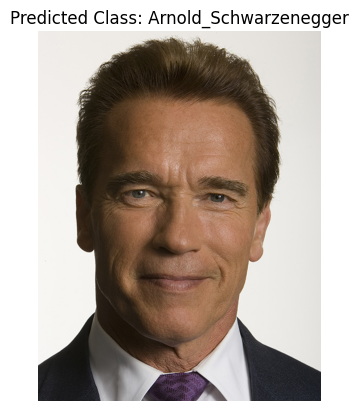

In [4]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation to match the input size and normalization
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),  # Resize the image to the same size as the model's input
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize with the same values used during training
])

# Function to predict the image
def predict_image(image_path):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    original_img = img.copy()
    
    img = transform(img)  # Apply transformations

    # Add batch dimension (1, C, H, W)
    img = img.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make a prediction
    with torch.no_grad():
        logits = model(img)
        prediction = logits.argmax(dim=1)  # Get the predicted class label

    return prediction.item(), original_img

# Example 1 (True)
image_path = "/kaggle/input/testing-individuals/Test_3.jpg"
predicted_class, image_to_show = predict_image(image_path)

predicted_class_name = class_to_idx[predicted_class]
print(f"Actual Class: Arnold Schwarzenegger")

# Display the image with predicted class
plt.imshow(image_to_show)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()

Actual Class: Donald Rumsfeld


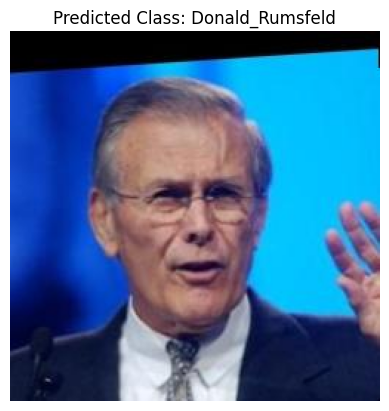

In [5]:
# Example 2 (True)
image_path = "/kaggle/input/testing-individuals/Test_6.jpg"
predicted_class, image_to_show = predict_image(image_path)

predicted_class_name = class_to_idx[predicted_class]
print(f"Actual Class: Donald Rumsfeld")

# Display the image with predicted class
plt.imshow(image_to_show)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()

Actual Class: Jennifer Lopez


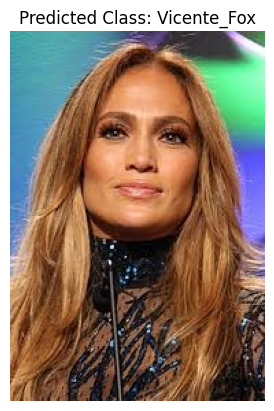

In [6]:
# Example 3 (False)
image_path = "/kaggle/input/testing-individuals/Test_7.jpeg"
predicted_class, image_to_show = predict_image(image_path)

predicted_class_name = class_to_idx[predicted_class]
print(f"Actual Class: Jennifer Lopez")

# Display the image with predicted class
plt.imshow(image_to_show)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()

--- Generating Confusion Matrix ---
Displaying confusion matrix for the first 50 classes found.


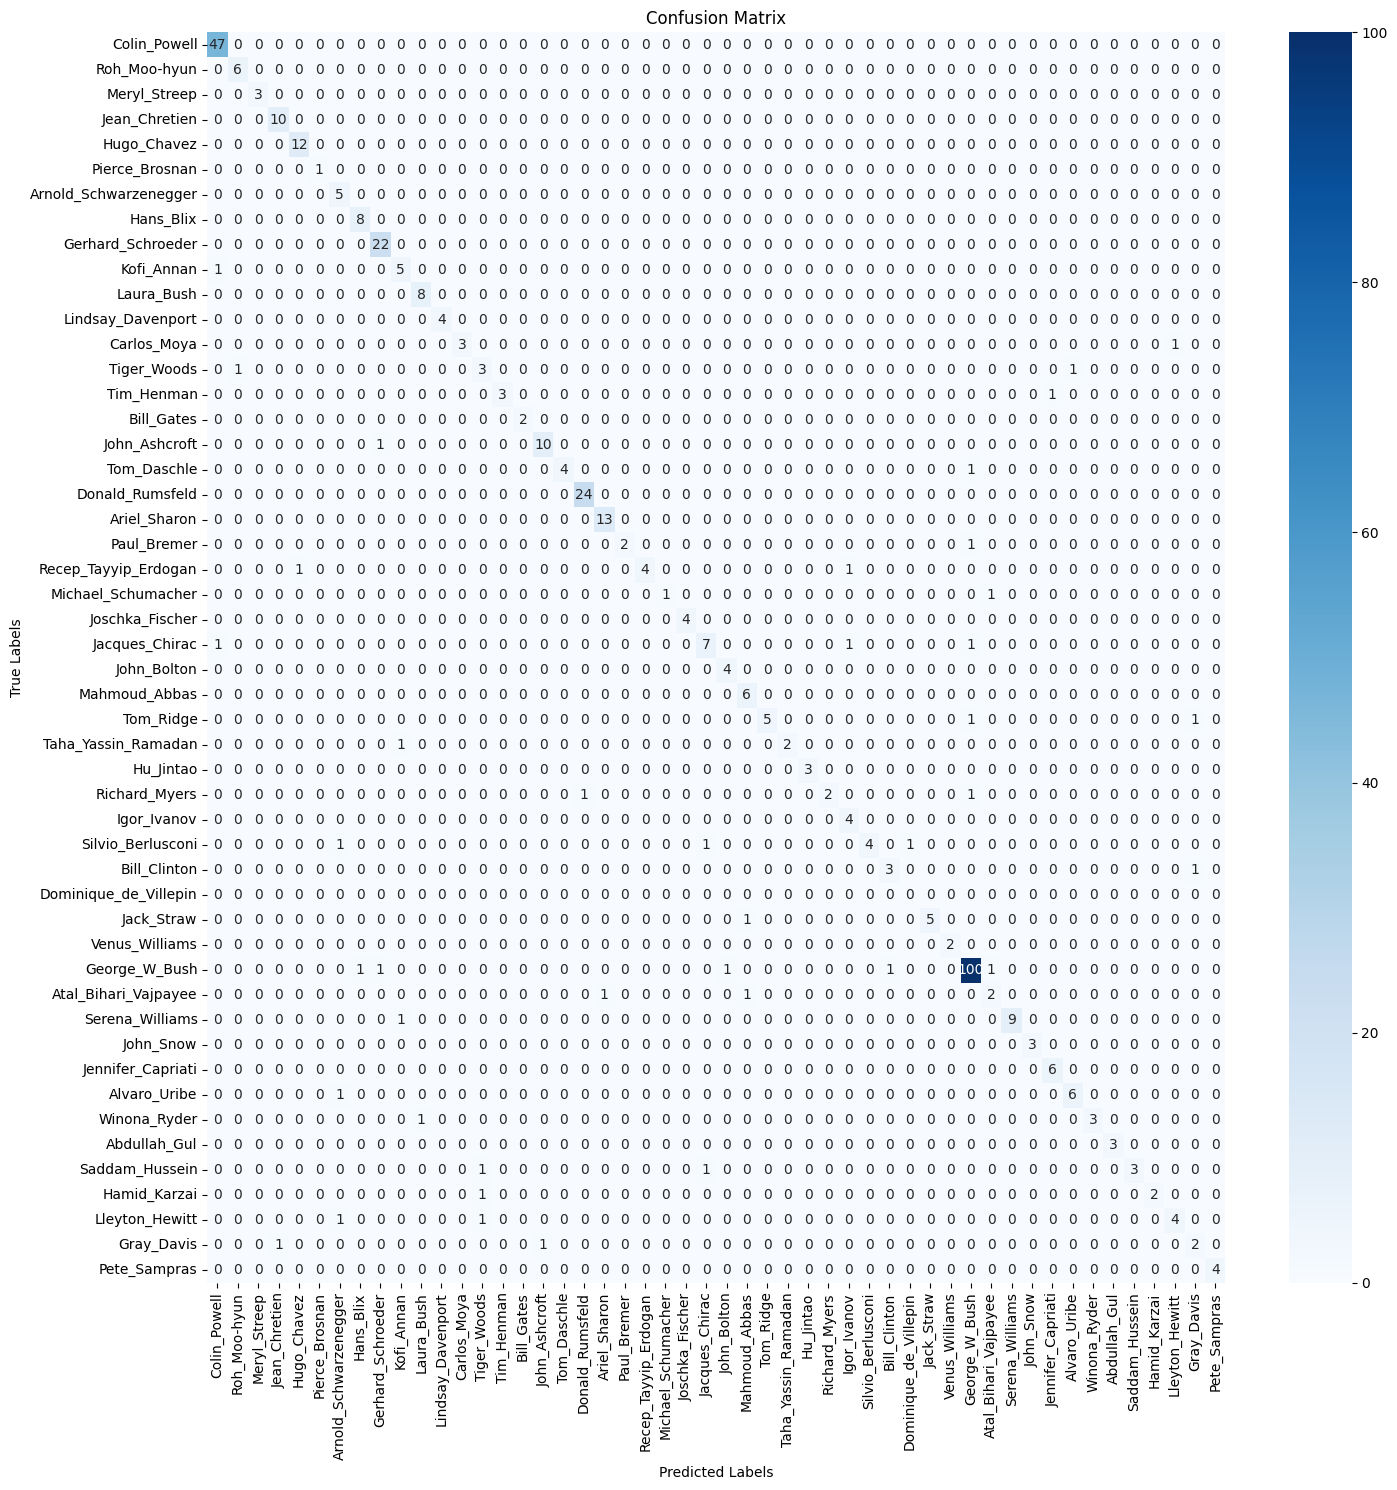


--- Generating Per-Class Accuracy ---
Displaying per-class accuracy for 50 classes (sorted by accuracy).


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


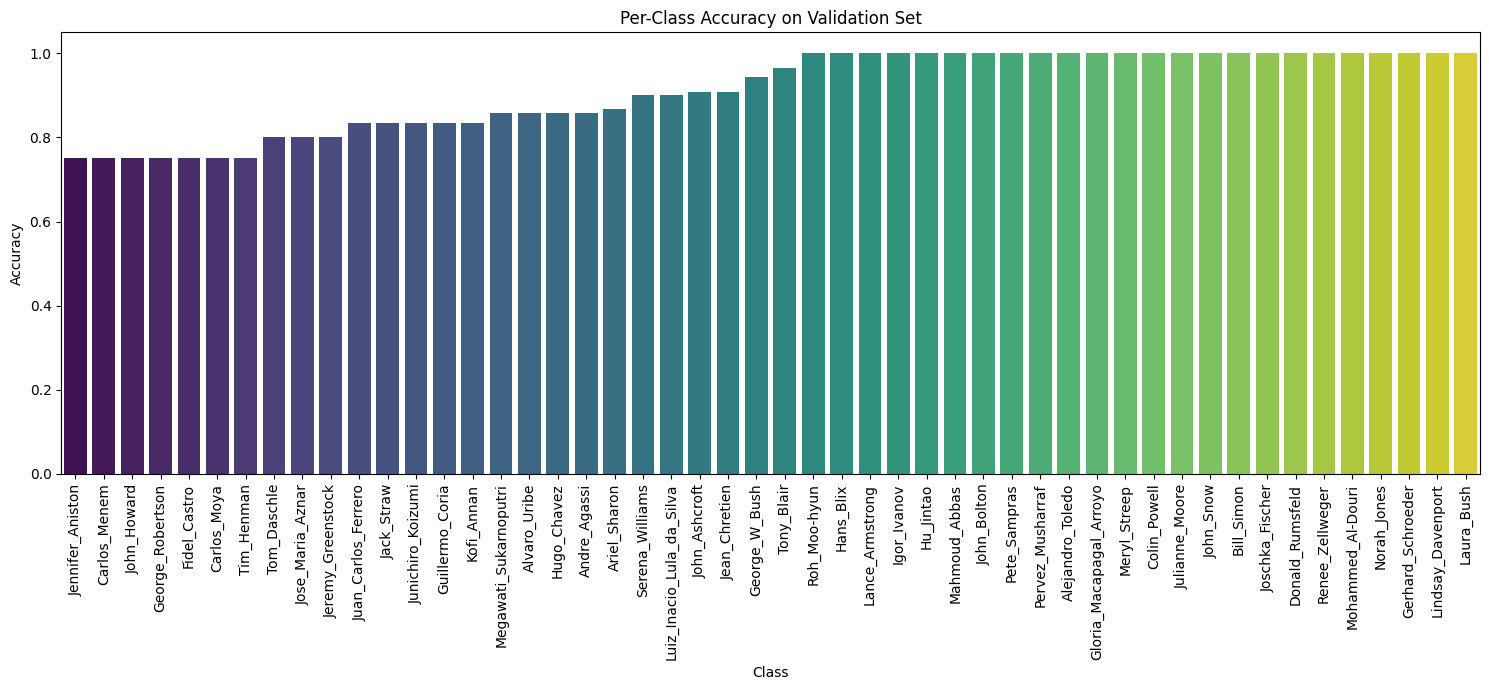


--- Generating Misclassified Examples ---
Found 135 misclassifications.


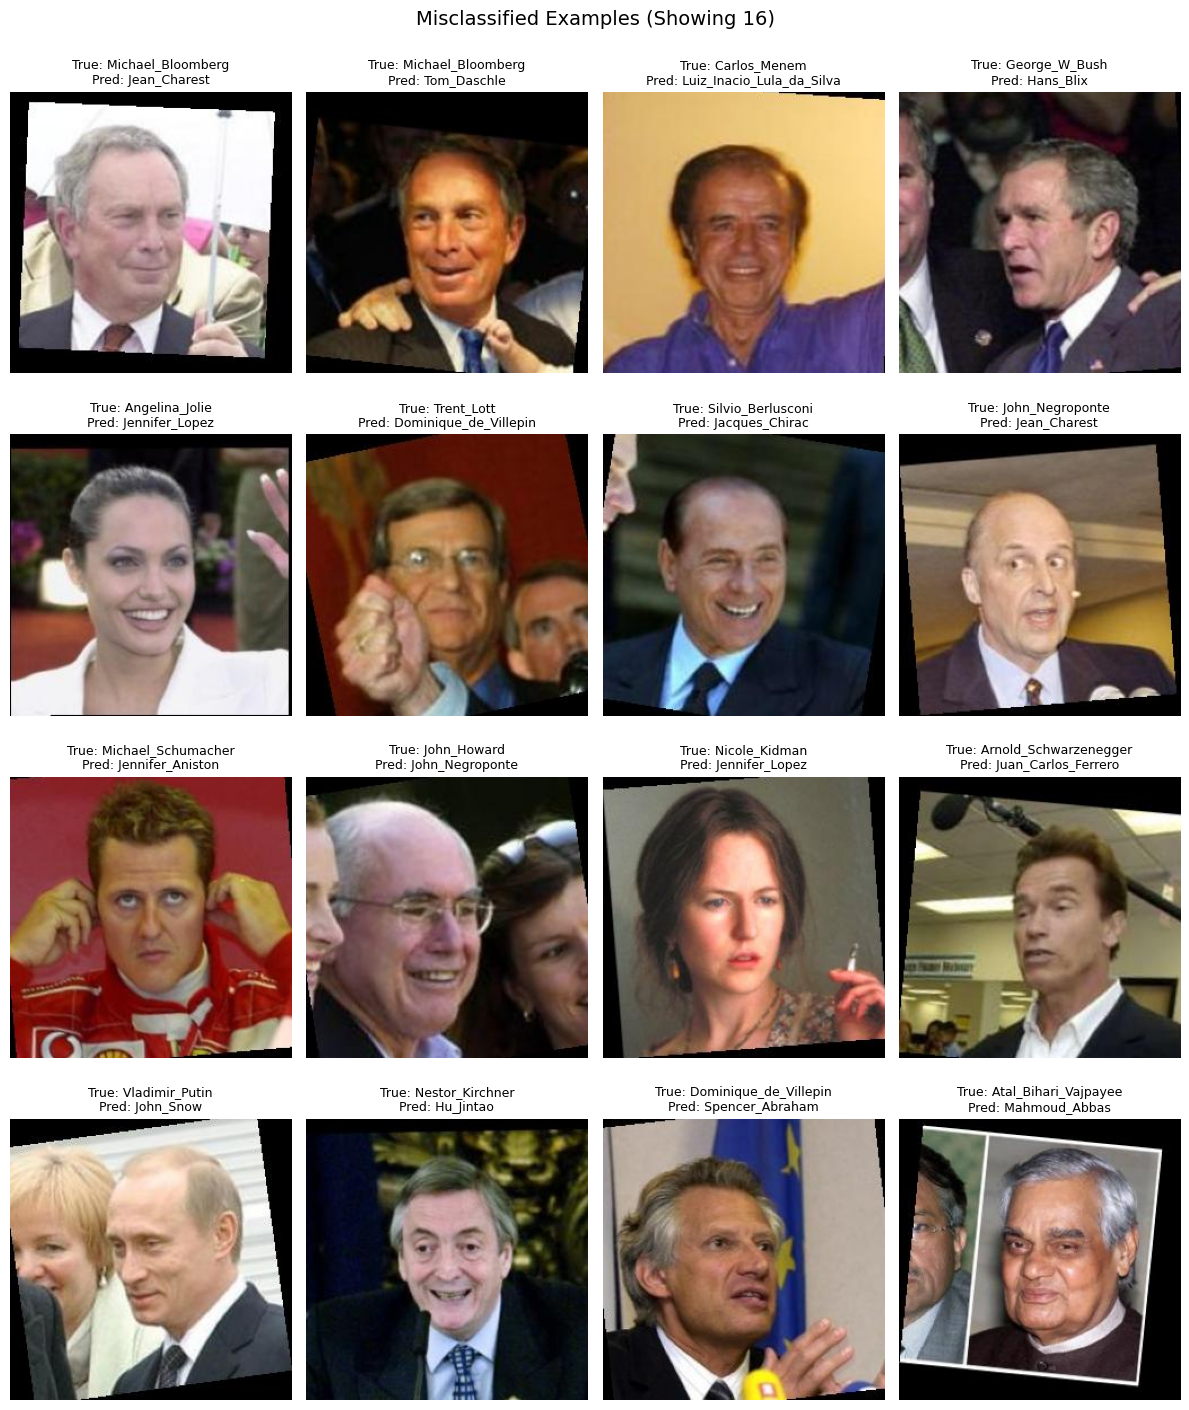


--- Generating Correctly Classified Examples ---
Found 584 correct classifications.


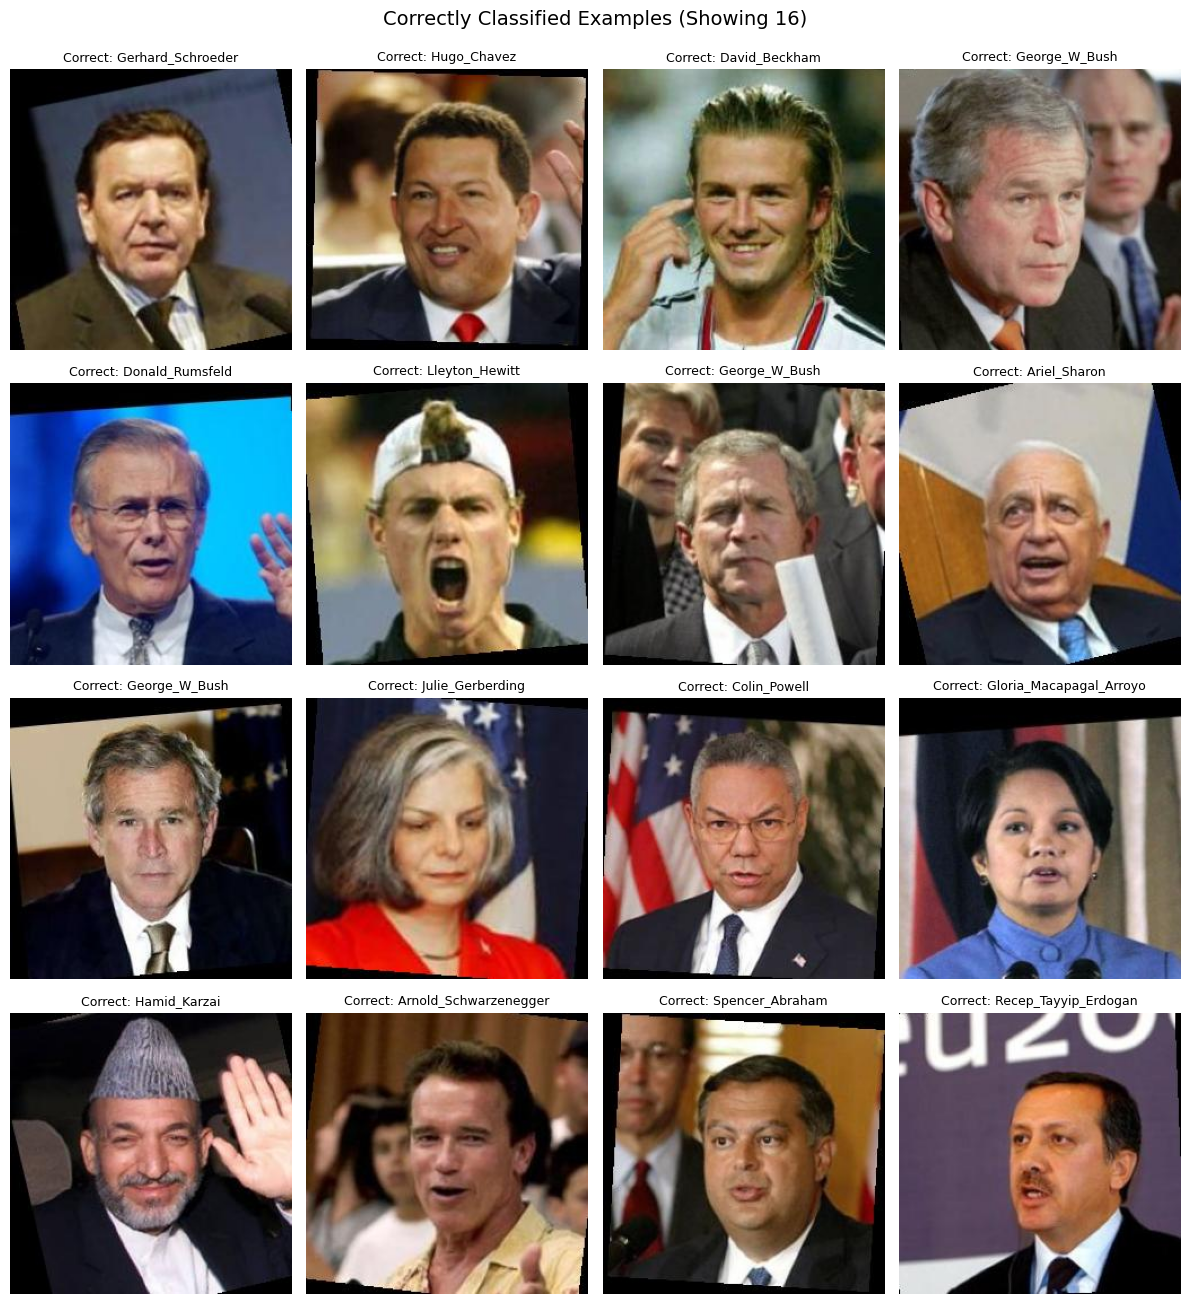

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
from PIL import Image
import random
import math

# Ensure labels and predictions are numpy arrays
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)

# Get class names, handling potential gaps in indices if needed
target_names = ["Unknown"] * num_classes
if class_to_idx:
    for idx, name in class_to_idx.items():
        # Ensure idx is treated as an integer if it comes from dict keys
        try:
             idx_int = int(idx)
             if 0 <= idx_int < num_classes:
                 target_names[idx_int] = name
             else:
                 print(f"Warning: Index {idx_int} from class_to_idx is out of bounds for num_classes={num_classes}")
        except ValueError:
             print(f"Warning: Could not convert index {idx} to integer from class_to_idx.")
else:
    print("Warning: class_to_idx not found in checkpoint. Using generic class names.")
    target_names = [f"Class {i}" for i in range(num_classes)]

# --- 1. Confusion Matrix ---
def plot_confusion_matrix(labels, preds, class_names, figsize=(15, 15), max_classes_display=50):
    """Plots a confusion matrix heatmap."""
    print("--- Generating Confusion Matrix ---")
    unique_present_labels = np.unique(np.concatenate((labels, preds)))
    cm = confusion_matrix(labels, preds, labels=unique_present_labels)
    num_actual_classes = cm.shape[0] # Number of classes actually present

    if num_actual_classes == 0:
        print("Warning: No classes found in labels/predictions. Skipping confusion matrix.")
        return None # Return None if no matrix generated

    current_display_names = [class_names[i] for i in unique_present_labels if i < len(class_names)]
    if len(current_display_names) != num_actual_classes:
         print(f"Warning: CM display name length ({len(current_display_names)}) != actual classes ({num_actual_classes}). Truncating/adjusting.")
         current_display_names = current_display_names[:num_actual_classes]

    cm_display = cm
    final_display_names = current_display_names

    if num_actual_classes > max_classes_display:
        # print(f"Warning: Number of classes present ({num_actual_classes}) > {max_classes_display}. Displaying subset.")
        # Simple approach: take the first N for display consistency
        indices_to_show = list(range(max_classes_display))
        cm_display = cm[np.ix_(indices_to_show, indices_to_show)] # Slice the matrix
        final_display_names = [current_display_names[i] for i in indices_to_show]
        print(f"Displaying confusion matrix for the first {max_classes_display} classes found.")

    plt.figure(figsize=figsize)
    sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues',
                xticklabels=final_display_names, yticklabels=final_display_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
    return cm # Return the original full matrix for potential further use

# Plot the confusion matrix
conf_matrix = plot_confusion_matrix(all_labels_np, all_preds_np, target_names, max_classes_display=50)


# # --- 2. Training & Validation Curves ---
# def plot_learning_curves(history):
#     """Plots training/validation loss and accuracy curves."""
#     if not history or not all(k in history for k in ['train_loss', 'val_loss', 'train_acc', 'val_acc']):
#         print("\n--- Skipping Learning Curves (History data not found/incomplete) ---")
#         return

#     print("\n--- Generating Learning Curves ---")
#     epochs = range(1, len(history['train_loss']) + 1)

#     plt.figure(figsize=(14, 5))

#     # Plot Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
#     plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
#     plt.title('Training and Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)

#     # Plot Accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
#     plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
#     plt.title('Training and Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()

# Attempt to load history if checkpoint exists and contains it
# Ensure 'checkpoint' variable exists if loading from it
history_data_found = False
if 'checkpoint' in locals() and isinstance(checkpoint, dict) and 'history' in checkpoint:
     history_data = checkpoint['history']
     plot_learning_curves(history_data)
     history_data_found = True
elif 'history' in locals() and isinstance(history, dict): # Check if history exists from the training script run
     plot_learning_curves(history)
     history_data_found = True

# if not history_data_found:
#      print("\n--- Skipping Learning Curves (History data not available in 'checkpoint' or 'history' variable) ---")


# # --- 3. Classification Report (Optional Regeneration) ---
# print("\n--- Classification Report ---")
# try:
#     present_labels_indices = sorted(list(np.unique(np.concatenate((all_labels_np, all_preds_np)))))
#     if not present_labels_indices:
#          print("No labels/predictions found to generate report.")
#     else:
#         filtered_target_names = [target_names[i] for i in present_labels_indices if i < len(target_names)]
#         # Ensure target names match the number of labels being reported
#         if len(filtered_target_names) != len(present_labels_indices):
#              print(f"Warning: Mismatch between filtered target names ({len(filtered_target_names)}) and present labels ({len(present_labels_indices)}). Using generic names for report.")
#              filtered_target_names = [f"Class {i}" for i in present_labels_indices]

#         report = classification_report(
#             all_labels_np, all_preds_np,
#             labels=present_labels_indices,
#             target_names=filtered_target_names,
#             zero_division=0
#         )
#         print(report)
#     overall_accuracy = accuracy_score(all_labels_np, all_preds_np)
#     print(f"\nOverall Validation Accuracy: {overall_accuracy:.4f}")
# except Exception as e:
#     print(f"Could not generate classification report: {e}")


# --- 4. Per-Class Accuracy (Bar Chart) ---
def plot_per_class_accuracy(labels, preds, class_names, figsize=(15, 7), max_classes_display=50):
    """Plots accuracy for each class using a bar chart."""
    print("\n--- Generating Per-Class Accuracy ---")

    unique_present_labels = np.unique(np.concatenate((labels, preds)))
    if len(unique_present_labels) == 0:
         print("Warning: No unique labels found. Skipping per-class accuracy plot.")
         return

    cm = confusion_matrix(labels, preds, labels=unique_present_labels)
    num_actual_classes = cm.shape[0]

    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_acc = cm.diagonal() / cm.sum(axis=1)
        per_class_acc[np.isnan(per_class_acc)] = 0

    current_display_names = [class_names[i] for i in unique_present_labels if i < len(class_names)]
    if len(current_display_names) != num_actual_classes:
         print(f"Warning: Length mismatch after getting names ({len(current_display_names)}) vs unique labels ({num_actual_classes}). Check class_names mapping.")
         current_display_names = current_display_names[:num_actual_classes]

    indices_to_plot = np.arange(num_actual_classes)
    per_class_acc_display = per_class_acc
    final_display_names = current_display_names

    if num_actual_classes > max_classes_display:
        # print(f"Warning: Number of classes present ({num_actual_classes}) > {max_classes_display}. Displaying subset.")
        sorted_indices_in_present = np.argsort(per_class_acc)
        top_n_indices_in_present = sorted_indices_in_present[-max_classes_display:]

        per_class_acc_display = per_class_acc[top_n_indices_in_present]
        final_display_names = [current_display_names[i] for i in top_n_indices_in_present]
        ticks_display = list(range(max_classes_display))
        print(f"Displaying per-class accuracy for {max_classes_display} classes (sorted by accuracy).")
    else:
        ticks_display = list(range(num_actual_classes))

    plt.figure(figsize=figsize)
    if len(ticks_display) > 0:
        sns.barplot(x=ticks_display, y=per_class_acc_display, palette="viridis")
        plt.xlabel("Class")
        plt.ylabel("Accuracy")
        plt.title("Per-Class Accuracy on Validation Set")
        plt.xticks(ticks=ticks_display, labels=final_display_names, rotation=90)
        plt.ylim(0, 1.05)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping plot as there are no classes to display after filtering/processing.")

# Plot per-class accuracy
plot_per_class_accuracy(all_labels_np, all_preds_np, target_names, max_classes_display=50)


# --- 5. Examples of Misclassified Images ---
def show_misclassified_images(labels, preds, val_subset, full_dataset, class_names, num_examples=16):
    """Shows a grid of misclassified images with true and predicted labels."""
    print("\n--- Generating Misclassified Examples ---")
    # Ensure val_subset and full_dataset are available
    if 'val_subset' not in locals() or 'full_dataset' not in locals():
         print("Skipping: 'val_subset' or 'full_dataset' not found.")
         return
    if not hasattr(val_subset, 'indices') or not hasattr(full_dataset, 'images'):
        print("Skipping: Required attributes missing from dataset objects.")
        return

    misclassified_indices_subset = np.where(preds != labels)[0]

    if len(misclassified_indices_subset) == 0:
        print("No misclassifications found!")
        return

    print(f"Found {len(misclassified_indices_subset)} misclassifications.")
    num_examples = min(num_examples, len(misclassified_indices_subset))
    random_indices = random.sample(list(misclassified_indices_subset), num_examples)

    ncols = int(math.sqrt(num_examples))
    nrows = math.ceil(num_examples / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3.5))
    if num_examples == 1: axes = np.array([axes]) # Handle single subplot case
    axes = axes.flatten()

    for i, subset_idx in enumerate(random_indices):
        try:
            original_idx = val_subset.indices[subset_idx]
            img_path = full_dataset.images[original_idx]
            true_label_idx = labels[subset_idx]
            pred_label_idx = preds[subset_idx]

            true_label_name = class_names[true_label_idx] if true_label_idx < len(class_names) else f"Unknown ({true_label_idx})"
            pred_label_name = class_names[pred_label_idx] if pred_label_idx < len(class_names) else f"Unknown ({pred_label_idx})"

            img = Image.open(img_path).convert("RGB")
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", fontsize=9)
            ax.axis("off")
        except IndexError:
            print(f"IndexError processing subset index {subset_idx}. Skipping example.")
            axes[i].set_title("Index Error", fontsize=8)
            axes[i].axis("off")
        except Exception as e:
            print(f"Error processing example for subset index {subset_idx}: {e}")
            # Check if img_path was defined before trying to print it
            img_path_str = img_path if 'img_path' in locals() and i == enumerate(random_indices).index else "Unknown path"
            print(f"-> Image path potentially involved: {img_path_str}")
            axes[i].set_title("Error loading/plotting", fontsize=8)
            axes[i].axis("off")


    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.suptitle(f"Misclassified Examples (Showing {num_examples})", y=1.02, fontsize=14)
    plt.show()

# --- 6. Examples of Correctly Classified Images (NEW) ---
def show_correctly_classified_images(labels, preds, val_subset, full_dataset, class_names, num_examples=16):
    """Shows a grid of correctly classified images with their predicted labels."""
    print("\n--- Generating Correctly Classified Examples ---")
    # Ensure val_subset and full_dataset are available
    if 'val_subset' not in locals() or 'full_dataset' not in locals():
         print("Skipping: 'val_subset' or 'full_dataset' not found.")
         return
    if not hasattr(val_subset, 'indices') or not hasattr(full_dataset, 'images'):
        print("Skipping: Required attributes missing from dataset objects.")
        return

    correctly_classified_indices_subset = np.where(preds == labels)[0] # Find correct ones

    if len(correctly_classified_indices_subset) == 0:
        print("No correct classifications found! (This is unexpected)")
        return

    print(f"Found {len(correctly_classified_indices_subset)} correct classifications.")
    num_examples = min(num_examples, len(correctly_classified_indices_subset))
    # Select random examples from the correctly classified ones
    random_indices = random.sample(list(correctly_classified_indices_subset), num_examples)

    # Determine grid size
    ncols = int(math.sqrt(num_examples))
    nrows = math.ceil(num_examples / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3.2)) # Slightly adjusted figsize
    if num_examples == 1: axes = np.array([axes]) # Handle single subplot case
    axes = axes.flatten() # Flatten to easily iterate

    for i, subset_idx in enumerate(random_indices):
        try:
            # Map the index from the validation subset back to the original full dataset index
            original_idx = val_subset.indices[subset_idx]
            img_path = full_dataset.images[original_idx]
            # Since it's correct, true label index = predicted label index
            label_idx = labels[subset_idx] # or preds[subset_idx]

            label_name = class_names[label_idx] if label_idx < len(class_names) else f"Unknown ({label_idx})"

            img = Image.open(img_path).convert("RGB")
            ax = axes[i]
            ax.imshow(img)
            # Simpler title for correct examples
            ax.set_title(f"Correct: {label_name}", fontsize=9)
            ax.axis("off")
        except IndexError:
            print(f"IndexError processing subset index {subset_idx}. Skipping example.")
            axes[i].set_title("Index Error", fontsize=8)
            axes[i].axis("off")
        except Exception as e:
            print(f"Error processing example for subset index {subset_idx}: {e}")
            img_path_str = img_path if 'img_path' in locals() and i == enumerate(random_indices).index else "Unknown path"
            print(f"-> Image path potentially involved: {img_path_str}")
            axes[i].set_title("Error loading/plotting", fontsize=8)
            axes[i].axis("off")


    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.suptitle(f"Correctly Classified Examples (Showing {num_examples})", y=1.02, fontsize=14)
    plt.show()

# --- Plot Examples ---
# Check if necessary dataset objects are available before calling
if 'val_ds' in locals() and 'full_val_dataset' in locals():
    show_misclassified_images(all_labels_np, all_preds_np, val_ds, full_val_dataset, target_names, num_examples=16)
    show_correctly_classified_images(all_labels_np, all_preds_np, val_ds, full_val_dataset, target_names, num_examples=16) # Call the new function
else:
    print("\n--- Skipping Misclassified/Correct Examples (Validation dataset objects 'val_ds' or 'full_val_dataset' not found) ---")